In [17]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran
import math

from numpy import dot
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import euclidean as euc

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

jungang_col = keti_db.jungang_pattern
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [46]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 100

def compile_and_fit(model, window, EPOCHS = 20,patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[
                    tf.metrics.MeanAbsoluteError(),
                    
                ])

  history = model.fit(window.train, epochs=EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [47]:
jungang_db_cur = jungang_col.find()
db_datas = [_ for _ in jungang_db_cur]

jg_datas = pd.DataFrame(columns=['Date Time','energy (kw 15min)'])
jg_datas['Date Time'] = [_['ttime'] for _ in db_datas]
jg_datas['energy (kw 15min)'] = [_['energy'] for _ in db_datas]

date_time = pd.to_datetime(jg_datas.pop('Date Time'),
                          format="%Y-%m-%d %H:%M:%S")
jg_datas.index = date_time


# 불 필요 데이터 잘라내기
idx = jg_datas.index.get_loc(jg_datas[jg_datas['energy (kw 15min)'] == 0].index[7])

jg_datas = jg_datas.iloc[:idx].copy()
jg_datas

,energy (kw 15min)
Date Time,
2017-01-01 00:00:00,15250
2017-01-01 00:15:00,15250
2017-01-01 00:30:00,13750
2017-01-01 00:45:00,14250
2017-01-01 01:00:00,14000
...,...
2018-09-19 22:45:00,18750
2018-09-19 23:00:00,18250
2018-09-19 23:15:00,18000


In [48]:
def calc_sin(ts, target_value):
    return np.sin(ts * (2 * np.pi / target_value)).values


def calc_cos(ts, target_value):
    return np.cos(ts * (2 * np.pi / target_value)).values


def get_season(month):
    if month in [3, 4, 5]:
        return "봄"
    elif month in [6, 7, 8]:
        return "여름"
    elif month in [9, 10, 11]:
        return "가을"
    else:
        return "겨울"


def get_season_from_idx(idx):
    if idx == 1:
        return "봄"
    elif idx == 2:
        return "여름"
    elif idx == 3:
        return "가을"
    elif idx == 4:
        return "겨울"


def get_season_to_idx(season):
    if season == "봄":
        return 1
    elif season == "여름":
        return 2
    elif season == "가을":
        return 3
    elif season == "겨울":
        return 4


SEASONS = ["봄", "여름", "가을", "겨울"]


def get_weather_to_idx(weather):
    if weather == "특이사항없음":
        return 1
    elif weather == "비":
        return 2
    elif weather == "눈":
        return 3

# ~ 2018 year data parsing
jg_datas = jg_datas[jg_datas.index.year <= 2018]
date_time = jg_datas.index
timestamp = date_time.map(dt.timestamp)

day = 24 * 60 * 60
week = 7 * day
year = (365) * day

jg_datas['week sin'] = calc_sin(timestamp, week)
jg_datas['week cos'] = calc_cos(timestamp, week)
jg_datas['year sin'] = calc_sin(timestamp, year)
jg_datas['year cos'] = calc_cos(timestamp, year)
jg_datas['season'] = [get_season(_.month) for _ in jg_datas.index]
jg_datas['season idx'] = [get_season_to_idx(_) for _ in jg_datas['season'].values]

jg_datas = jg_datas[::4]
jg_datas

,energy (kw 15min),week sin,week cos,year sin,year cos,season,season idx
Date Time,,,,,,,
2017-01-01 00:00:00,15250,0.707107,-0.707107,0.198782,0.980044,겨울,4
2017-01-01 01:00:00,14000,0.680173,-0.733052,0.199485,0.979901,겨울,4
2017-01-01 02:00:00,14750,0.652287,-0.757972,0.200188,0.979758,겨울,4
2017-01-01 03:00:00,29500,0.623490,-0.781831,0.200891,0.979614,겨울,4
2017-01-01 04:00:00,15750,0.593820,-0.804598,0.201593,0.979469,겨울,4
...,...,...,...,...,...,...,...
2018-09-19 19:00:00,22500,-0.500000,0.866025,-0.999984,-0.005738,가을,3
2018-09-19 20:00:00,19250,-0.467269,0.884115,-0.999987,-0.005021,가을,3
2018-09-19 21:00:00,20250,-0.433884,0.900969,-0.999991,-0.004304,가을,3


In [49]:
# 날씨 데이터 가져오기
weather_df = pd.DataFrame(columns=['weather', 'avg ta', 'avg rhm'])
for weather in weather_col.find():
    try:
        iscs = weather['weather']
    except:
        iscs = "특이사항없음"
    if iscs != "특이사항없음":
        iscs_idx = 0
        for hours in range(0, 24):
            if (iscs[iscs_idx]['end time'] == ""):
                iscs[iscs_idx]['end time'] = weather['date'].replace(
                    hour=23)
            if (hours >= iscs[iscs_idx]['start time'].hour) and \
                    (hours <= iscs[iscs_idx]['end time'].hour):
                weather_df = weather_df.append({
                    "weather": iscs[iscs_idx]['weather'],
                    "avg ta": weather['avgTa'],
                    "avg rhm": weather['avgRhm']
                }, ignore_index=True)
            else:
                weather_df = weather_df.append({
                    "weather": "특이사항없음",
                    "avg ta": weather['avgTa'],
                    "avg rhm": weather['avgRhm']
                }, ignore_index=True)

            if ((iscs_idx + 1) < len(iscs)) and \
                    (iscs[iscs_idx]['end time'].hour < (hours + 1)):
                iscs_idx += 1
    else:
        for hours in range(0, 24):
            weather_df = weather_df.append({
                "weather": "특이사항없음",
                "avg ta": weather['avgTa'],
                "avg rhm": weather['avgRhm']
            }, ignore_index=True)

all_data_length = len(jg_datas)
jg_datas['weather'] = list(weather_df['weather'].values)[
    :all_data_length]
jg_datas['weather idx'] = list(get_weather_to_idx(
    _) for _ in weather_df['weather'].values)[:all_data_length]
jg_datas['avg ta'] = list(map(float, weather_df['avg ta'].values))[
    :all_data_length]
jg_datas['avg rhm'] = list(map(float, weather_df['avg rhm'].values))[
    :all_data_length]

jg_datas

,energy (kw 15min),week sin,week cos,year sin,year cos,season,season idx,weather,weather idx,avg ta,avg rhm
Date Time,,,,,,,,,,,
2017-01-01 00:00:00,15250,0.707107,-0.707107,0.198782,0.980044,겨울,4,특이사항없음,1,2.7,75.9
2017-01-01 01:00:00,14000,0.680173,-0.733052,0.199485,0.979901,겨울,4,특이사항없음,1,2.7,75.9
2017-01-01 02:00:00,14750,0.652287,-0.757972,0.200188,0.979758,겨울,4,특이사항없음,1,2.7,75.9
2017-01-01 03:00:00,29500,0.623490,-0.781831,0.200891,0.979614,겨울,4,특이사항없음,1,2.7,75.9
2017-01-01 04:00:00,15750,0.593820,-0.804598,0.201593,0.979469,겨울,4,특이사항없음,1,2.7,75.9
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-19 19:00:00,22500,-0.500000,0.866025,-0.999984,-0.005738,가을,3,비,2,22.1,59.1
2018-09-19 20:00:00,19250,-0.467269,0.884115,-0.999987,-0.005021,가을,3,비,2,22.1,59.1
2018-09-19 21:00:00,20250,-0.433884,0.900969,-0.999991,-0.004304,가을,3,비,2,22.1,59.1


In [50]:
all_dict = dict()
train_type = ['univariate', 
              'multivariate', 
#               'season univariate', 
#               'season multivariate', 
              'multivariate (ta-rhm)', 
              'multivariate (week)', 
              'multivariate (weather)',
              'multivariate (season)',              
              'multivariate (week-season)',              
              'with cluster label',
              'with cluster label (multivariate)',
              'with cluster label (multivariate-weather)',
              'with cluster label (multivariate-ta-rhm)',
              'with cluster label (multivariate-week)',
              'with cluster label (multivariate-season)',
              'with cluster label (multivariate-week-season)'              
             ]
uni_columns = ['energy (kw 15min)']
mul_week_columns = ['energy (kw 15min)', 'week sin', 'week cos']
mul_only_season_columns = ['energy (kw 15min)', 'season idx']
mul_weather_columns = ['energy (kw 15min)', 'weather idx']
mul_season_columns = ['energy (kw 15min)', 'week sin', 'week cos', 'season idx']
mul_ta_rhm_columns = ['energy (kw 15min)', 'avg ta', 'avg rhm'] 
mul_columns = ['energy (kw 15min)', 'week sin', 'week cos', 'year sin', 'year cos', 'season idx', 'avg ta', 'avg rhm']
seasons = ["봄", "여름", "가을", "겨울"]

# Clusterinbg 가져오기 작업
cur_cluster_result = cluster_col.find({
    "uid": "jungang_pattern"
})
cluster_result = dict()

for data in cur_cluster_result:
    in_dict = pd.DataFrame(columns=['Label', 'Weekday'])
    in_dict.index.name = "Date Time"
    
    season = data['season']
    infos = data['info']
    
    dtime = [dt.strptime(_['date'], "%Y-%m-%d") for _ in infos]
    labels = [_['label'] for _ in infos]

    for idx, _ in enumerate(dtime):
        label = labels[idx]        
        in_dict.loc[_] = [label, _.weekday()]
        
    cluster_result[season] = in_dict
    
cluster_pattern_dict = dict()

for season in seasons:
    result = cluster_result[season]
    in_dict = pd.DataFrame(columns=[_ for _ in range(0, 24)])
    in_dict.index.name = "Label"
    
    labels = list(set(result['Label']))
    for label in labels:
        cluster_pattern = np.array([])
        date_in_labels = result[result['Label'] == label].index
        for date in date_in_labels:
            idx = jg_datas.index.get_loc(date)
            pattern = jg_datas.iloc[idx: idx+24]['energy (kw 15min)'].values
            cluster_pattern = np.append(cluster_pattern, pattern)
        cluster_pattern = cluster_pattern.reshape(-1,24).mean(axis=0)
        in_dict.loc[label] = cluster_pattern
        
    cluster_pattern_dict[season] = in_dict
    
# Clustering Matching
cluster_dist_dict = dict()
for season in cluster_result.keys():
    cluster_season_dict = dict()
    week_list = set(cluster_result[season]['Weekday'])
    for week in week_list:
        week_dist = cluster_result[season][
            cluster_result[season]['Weekday'] == week
        ]['Weekday'].groupby(cluster_result[season]['Label']).count().sort_values(ascending=False)
        week_top_label = week_dist.index[0]
        
        cluster_season_dict[week] = week_top_label
    cluster_dist_dict[season] = cluster_season_dict

In [51]:
cluster_pattern_col = pd.DataFrame(columns=['cluster energy'])
for idx in range(0, len(jg_datas), 24):
    datas = jg_datas.iloc[idx: idx + 24].copy()
    date = datas.index[0]
    
    season = get_season(date.month)
    weekday = date.weekday()
    label = cluster_dist_dict[season][weekday]
    c_pattern = cluster_pattern_dict[season].loc[label].values
    
    for idx, _ in enumerate(datas.index):
        cluster_pattern_col.loc[_] = c_pattern[idx]
        
cluster_pattern_col

,cluster energy
2017-01-01 00:00:00,18390.625000
2017-01-01 01:00:00,17125.000000
2017-01-01 02:00:00,16265.625000
2017-01-01 03:00:00,22843.750000
2017-01-01 04:00:00,19328.125000
...,...
2018-09-19 19:00:00,19027.777778
2018-09-19 20:00:00,13638.888889
2018-09-19 21:00:00,11486.111111
2018-09-19 22:00:00,10638.888889


In [52]:
day_1_size = 24
year_half_size = day_1_size * int(365 / 4) 
year_1_size = day_1_size * 365

is_switch = True

training_datas = jg_datas[:year_1_size]
validation_datas = jg_datas[year_1_size:
                        year_1_size + year_half_size]
testing_datas = jg_datas[year_1_size + year_half_size:]
if is_switch == True:
    tmp = validation_datas.copy()
    validation_datas = testing_datas.copy()
    testing_datas = tmp

In [53]:
for t_type in train_type:
    if 'week-season' in t_type:
        in_dict = dict()
        in_col = mul_season_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
#     if 'season' in t_type:
#         seasons_dict = dict()
#         for season in seasons:
#             season_dict = dict()
#             in_col = mul_columns if "multivariate" in t_type else uni_columns
            
#             season_dict['train'] = training_datas[in_col][training_datas['season'] == season].copy()
#             season_dict['val'] = validation_datas[in_col].copy()
#             season_dict['test'] = testing_datas[in_col].copy()
            
#             seasons_dict[season] = season_dict
#         all_dict[t_type] = seasons_dict
    elif 'weather' in t_type:
        in_dict = dict()
        in_col = mul_weather_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
    elif 'season' in t_type:
        in_dict = dict()
        in_col = mul_only_season_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
    elif 'week' in t_type:
        in_dict = dict()
        in_col = mul_week_columns
#         in_col = uni_columns if "univariate" in t_type else mul_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
    elif 'ta-rhm' in t_type:
        in_dict = dict()
        in_col = mul_ta_rhm_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
    else:
        in_dict = dict()
        in_col = mul_columns if "multivariate" in t_type else uni_columns
#         in_col = uni_columns if "univariate" in t_type else mul_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict

In [54]:
norm_all_dict = dict()

mean = training_datas.mean()
std = training_datas.std()

for key in all_dict.keys():
#     in_col = mul_week_columns if "week" in key else mul_season_columns if "season" in key else mul_columns if "multivariate" in key else uni_columns
#     in_col = uni_columns if "univariate" in key else mul_columns
    
    in_col = None
    
    if "week-season" in key:
        in_col = mul_season_columns
    elif "weather" in key:
        in_col = mul_weather_columns
    elif "season" in key:
        in_col = mul_only_season_columns
    elif "week" in key:
        in_col = mul_week_columns
    elif "ta-rhm" in key:
        in_col = mul_ta_rhm_columns
    elif "multivariate" in key:
        in_col = mul_columns
    else:
        in_col = uni_columns
        
    in_dict = all_dict[key].copy()
    m = mean[in_col]
    s = std[in_col]

    train = in_dict['train'].copy()
    val = in_dict['val'].copy()
    test = in_dict['test'].copy()

    in_dict['train'] = (train - m) / s
    in_dict['val'] = (val - m) / s
    in_dict['test'] = (test - m) / s
#     if "season" in key:
#         for season in seasons:
#             train = in_dict[season]['train'].copy()
#             val = in_dict[season]['val'].copy()
#             test = in_dict[season]['test'].copy()
            
#             in_dict[season]['train'] = (train - m) / s
#             in_dict[season]['val'] = (val - m) / s
#             in_dict[season]['test'] = (test - m) / s
#     else:
#         train = in_dict['train'].copy()
#         val = in_dict['val'].copy()
#         test = in_dict['test'].copy()
        
#         in_dict['train'] = (train - m) / s
#         in_dict['val'] = (val - m) / s
#         in_dict['test'] = (test - m) / s
        
    norm_all_dict[key] = in_dict

In [55]:
# Cluster Energy Norm
for key in norm_all_dict.keys():
    if "with cluster" in key:
        mean = all_dict[key]['train'].mean().values[0]
        std = all_dict[key]['train'].std().values[0]
        
        norm_cluster_pattern_col = (cluster_pattern_col.copy() - mean) / std
        c_norm_dict = norm_all_dict[key].copy()
        
        for c_key in c_norm_dict.keys():
            c_norm_dict[c_key]['cluster energy'] = norm_cluster_pattern_col['cluster energy']
        
        
        norm_all_dict[key] = c_norm_dict.copy()

In [56]:
windows = dict()
OUT_STEPS = 3

for key in norm_all_dict.keys():
    nad = norm_all_dict[key]

    window = dict()
    for WINDOW_WIDTH in range(3, 21):
        h_key = "{} hours".format(WINDOW_WIDTH)
        window[h_key] = WindowGenerator(
                    input_width=WINDOW_WIDTH,
                    label_width=OUT_STEPS,
                    shift=OUT_STEPS,
                    label_columns=uni_columns,
                    train_df=nad['train'],
                    val_df=nad['val'],
                    test_df=nad['test']
                )
    windows[key] = window

In [57]:
val_performance = dict()
performance = dict()
models = dict()
epochs = 50
INPUT_WIDTH = 3

for key in windows.keys():
    window = windows[key]
    
    val_perfor = dict()
    perfor = dict()
    model = dict()
        
    for WINDOW_WIDTH in range(INPUT_WIDTH, INPUT_WIDTH + 1):
        IPython.display.clear_output()
        print("##### {} Training Start #####".format(key))
        print("##### Hours is {} #####".format(WINDOW_WIDTH))
        h_key = "{} hours".format(WINDOW_WIDTH)
        num_features = norm_all_dict[key]['train'].shape[1]
        cur_window = window[h_key]

        multi_lstm_model = tf.keras.Sequential([
                # Shape [batch, time, features] => [batch, lstm_units]
                # Adding more `lstm_units` just overfits more quickly.
                tf.keras.layers.LSTM(64, return_sequences=False),
                # Shape => [batch, out_steps*features]
                tf.keras.layers.Dense(OUT_STEPS*num_features),
                # Shape => [batch, out_steps, features]
                tf.keras.layers.Reshape([OUT_STEPS, num_features])
            ])

        compile_and_fit(multi_lstm_model, cur_window, epochs)

        val_perfor[h_key] = multi_lstm_model.evaluate(
            cur_window.val
        )

        perfor[h_key] = multi_lstm_model.evaluate(
            cur_window.test
        )

        model[h_key] = multi_lstm_model

    val_performance[key] = val_perfor
    performance[key] = perfor
    models[key] = model

##### with cluster label (multivariate-week-season) Training Start #####
##### Hours is 3 #####
Epoch 1/50
274/274 [==============================] - 2s 4ms/step - loss: 0.5164 - mean_absolute_error: 0.5670 - val_loss: 0.3408 - val_mean_absolute_error: 0.4303
Epoch 2/50
274/274 [==============================] - 1s 3ms/step - loss: 0.3040 - mean_absolute_error: 0.4217 - val_loss: 0.2198 - val_mean_absolute_error: 0.3393
Epoch 3/50
274/274 [==============================] - 1s 3ms/step - loss: 0.1957 - mean_absolute_error: 0.3322 - val_loss: 0.1563 - val_mean_absolute_error: 0.2698
Epoch 4/50
274/274 [==============================] - 1s 3ms/step - loss: 0.1565 - mean_absolute_error: 0.2930 - val_loss: 0.1379 - val_mean_absolute_error: 0.2593
Epoch 5/50
274/274 [==============================] - 1s 3ms/step - loss: 0.1474 - mean_absolute_error: 0.2829 - val_loss: 0.1342 - val_mean_absolute_error: 0.2600
Epoch 6/50
274/274 [==============================] - 1s 3ms/step - loss: 0.1429 - m

univariate


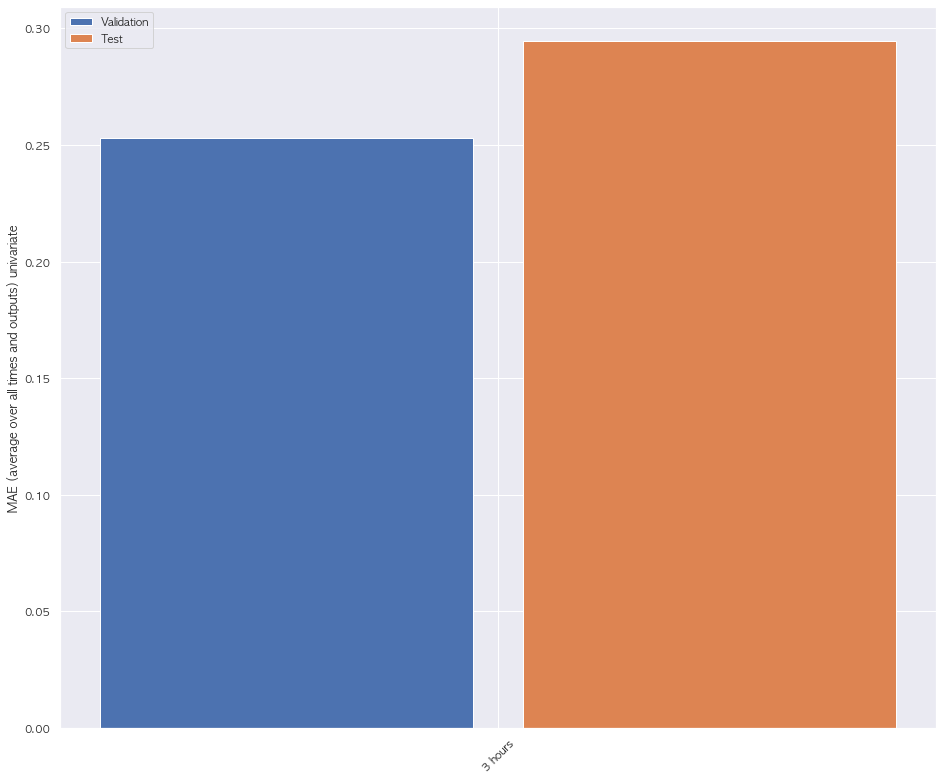

multivariate


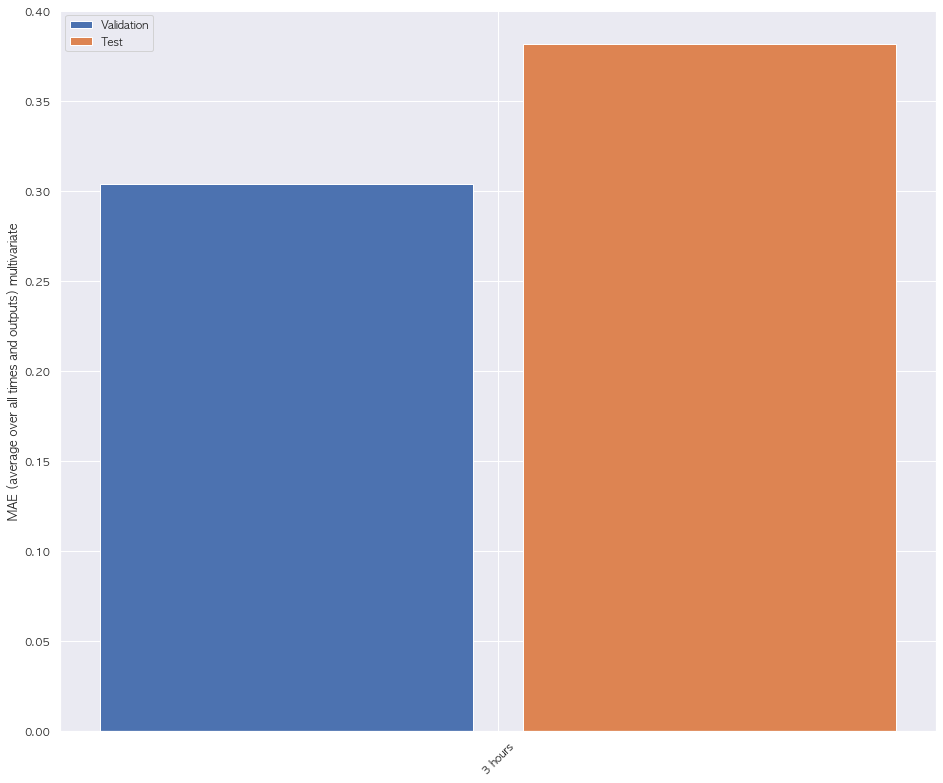

multivariate (ta-rhm)


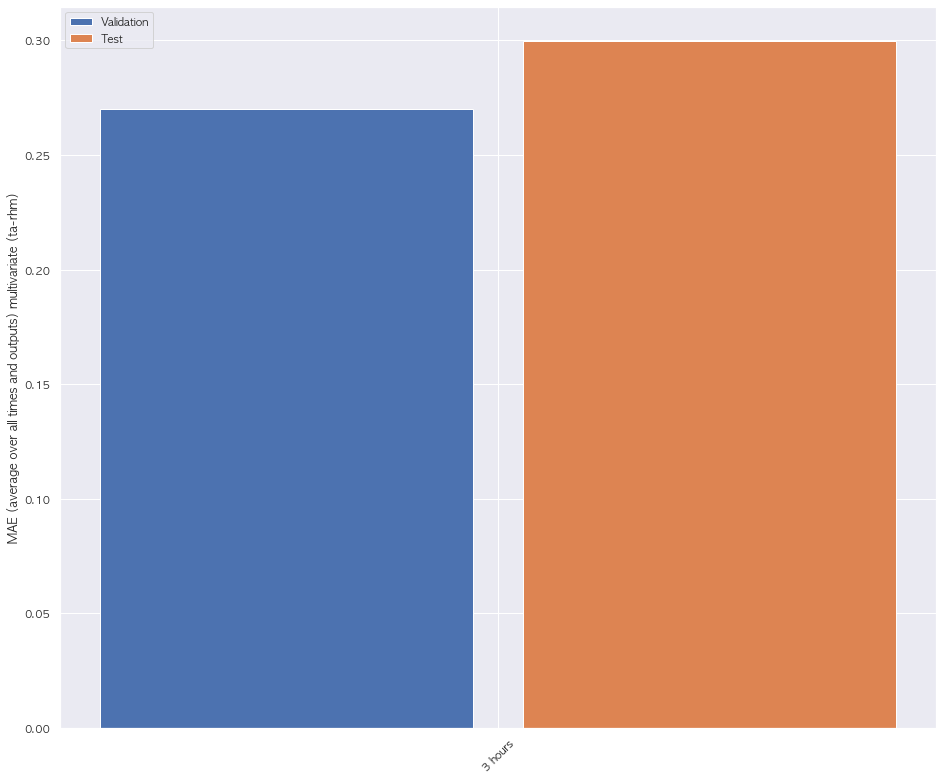

multivariate (week)


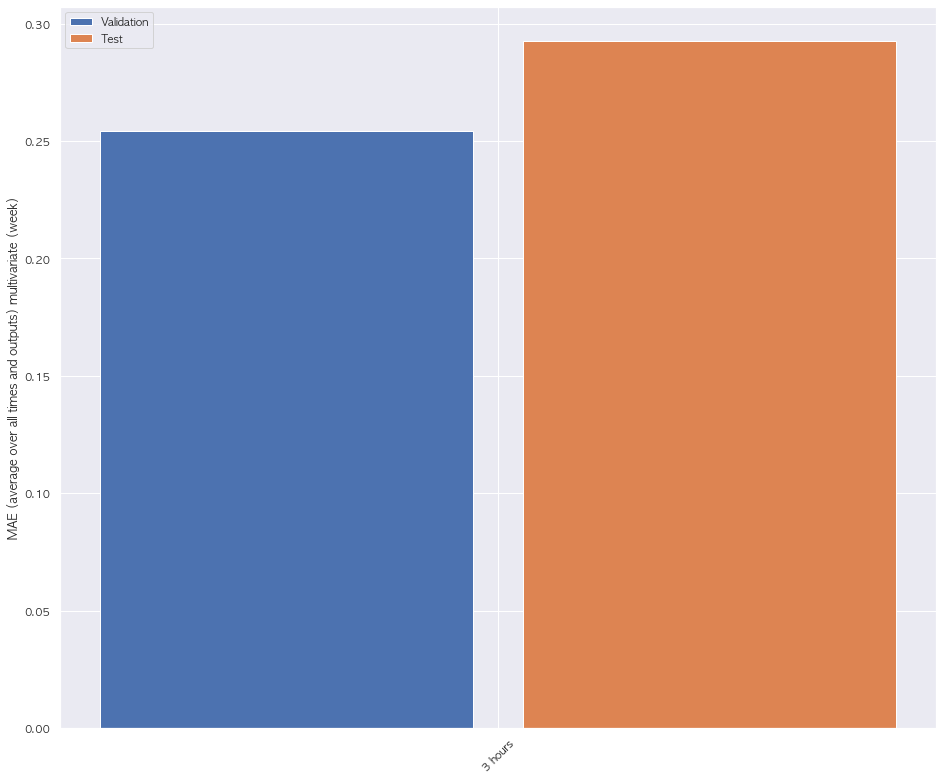

multivariate (weather)


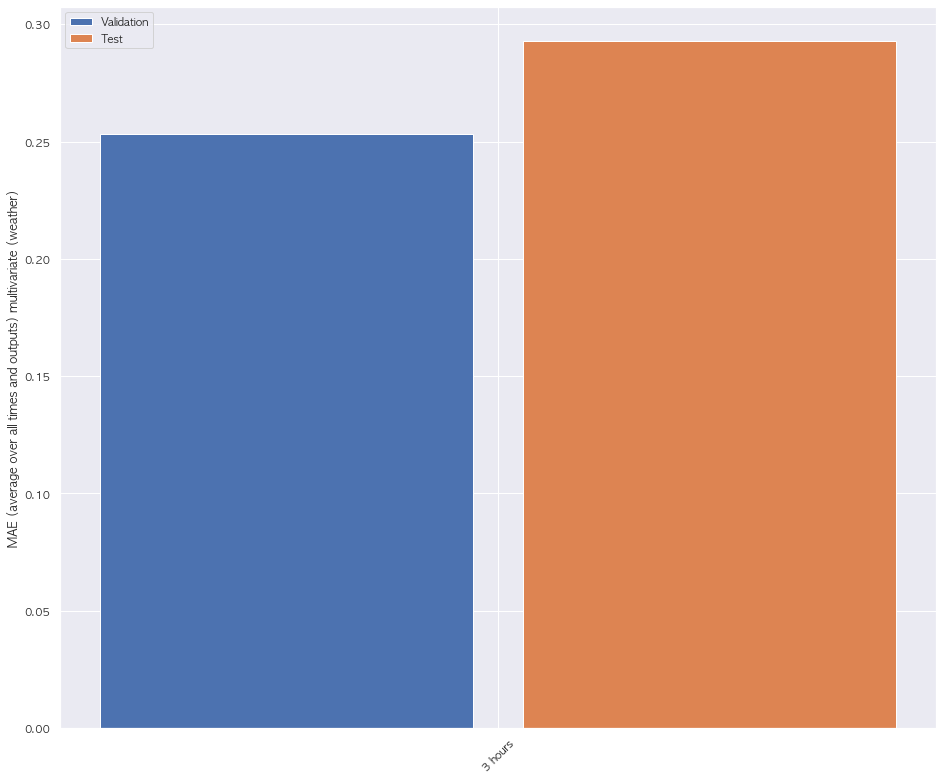

multivariate (season)


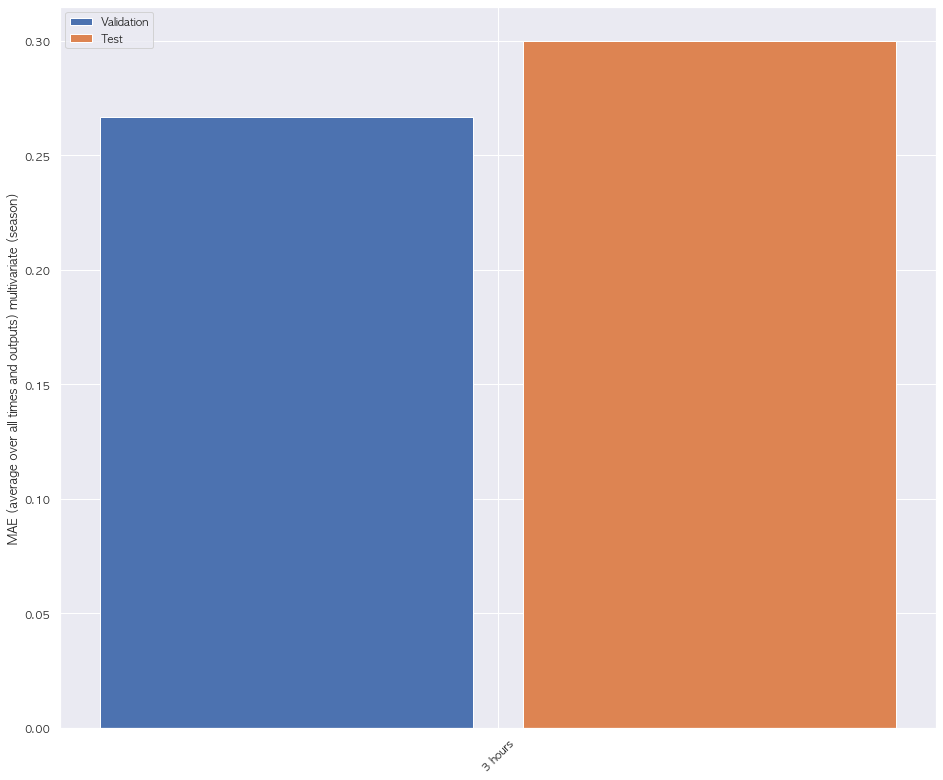

multivariate (week-season)


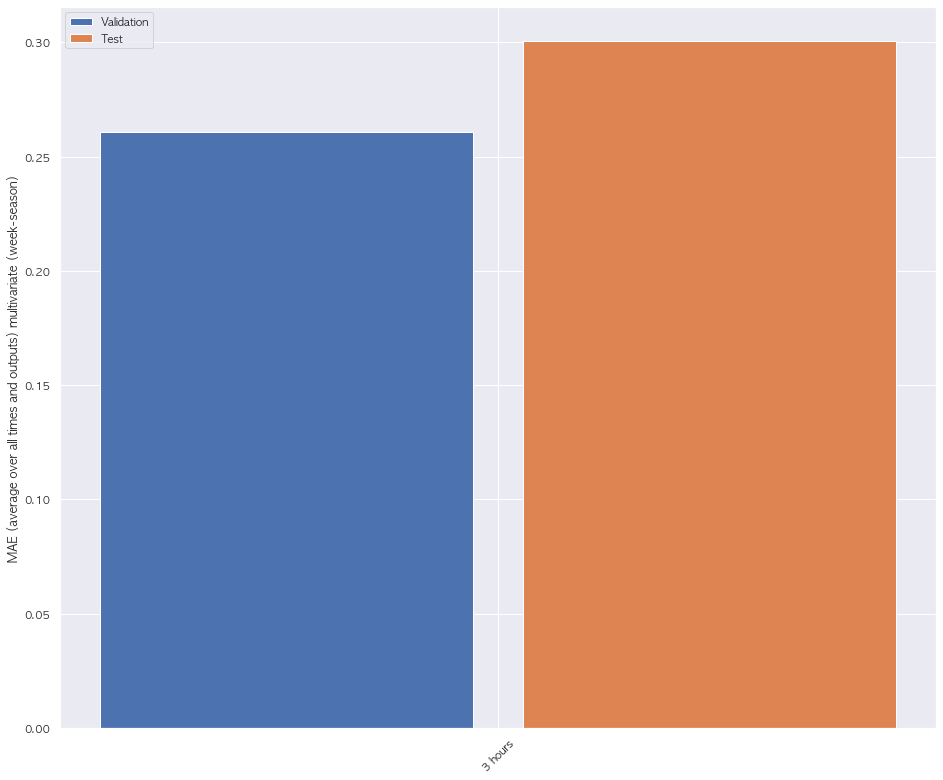

with cluster label


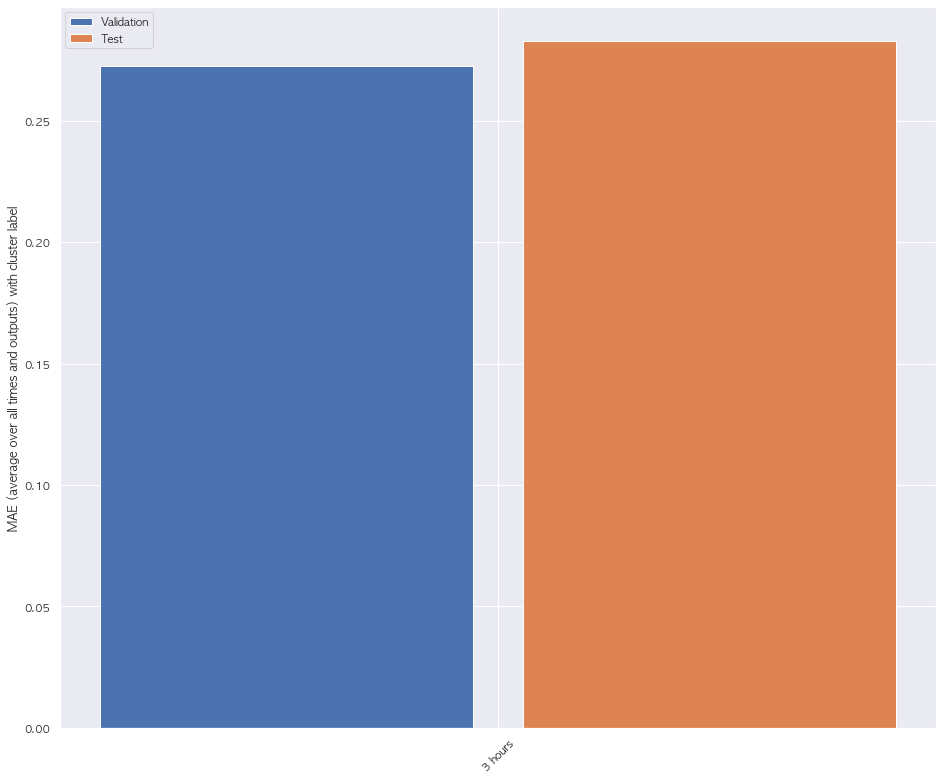

with cluster label (multivariate)


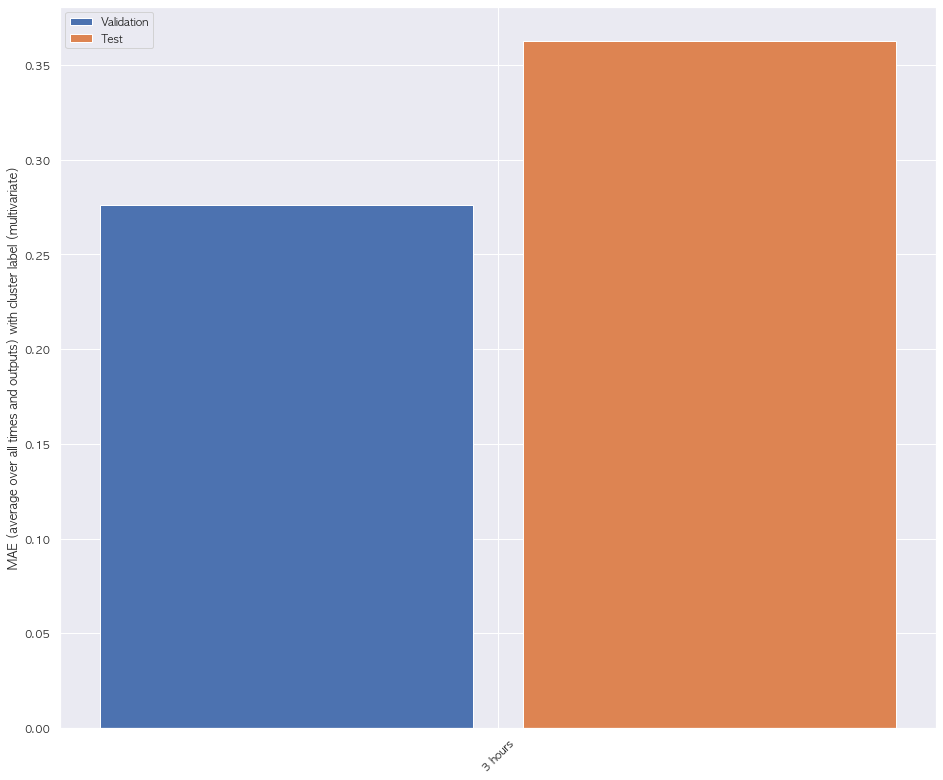

with cluster label (multivariate-weather)


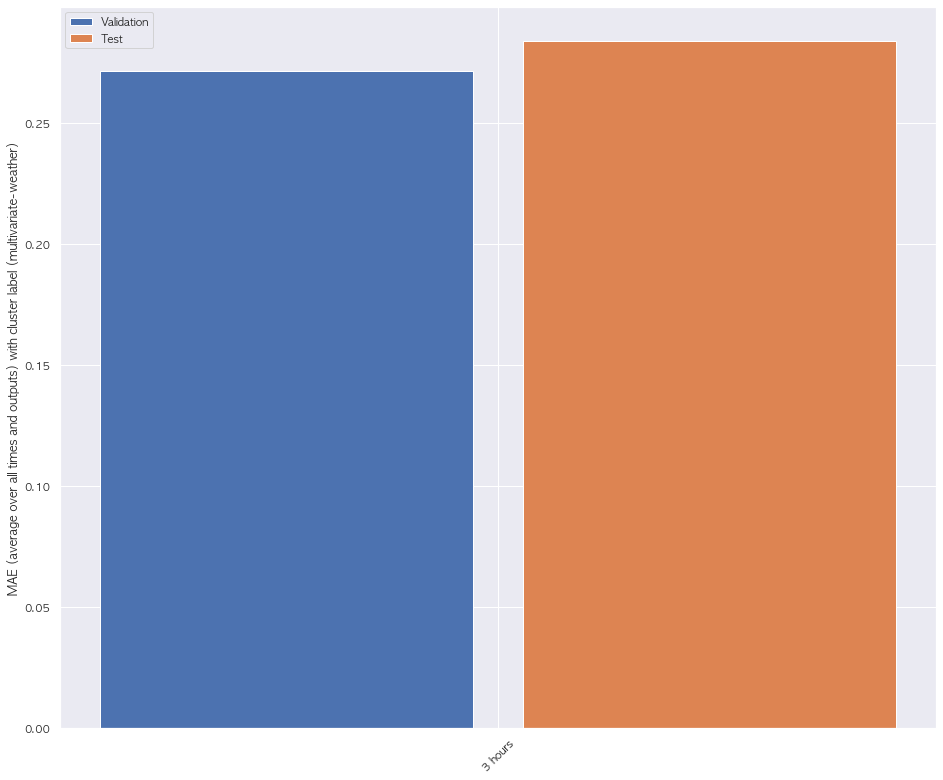

with cluster label (multivariate-ta-rhm)


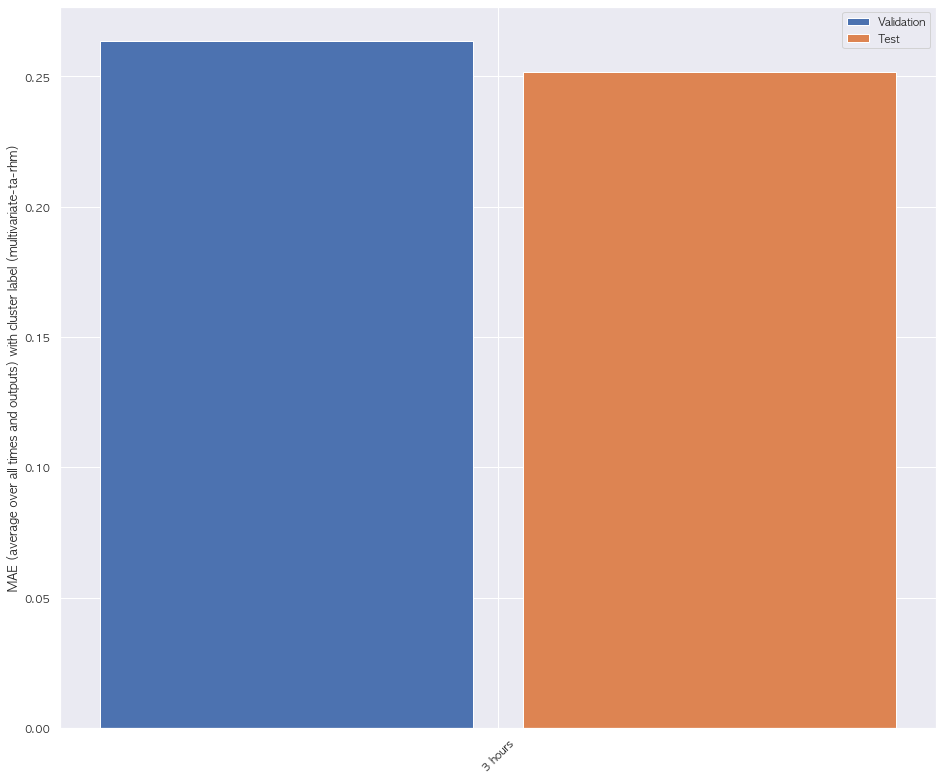

with cluster label (multivariate-week)


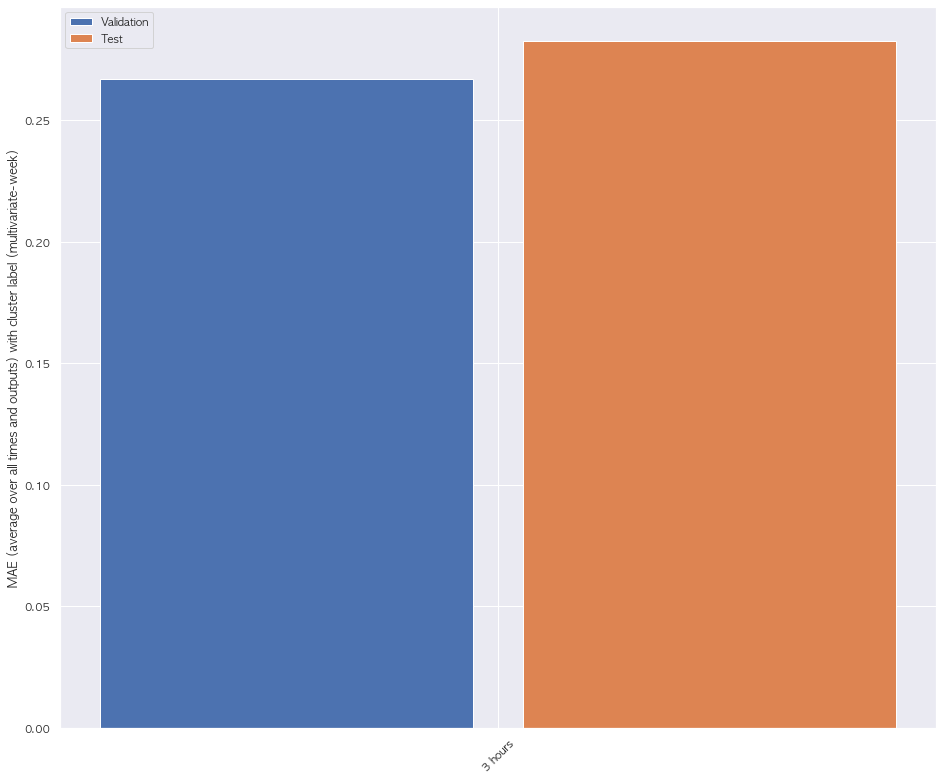

with cluster label (multivariate-season)


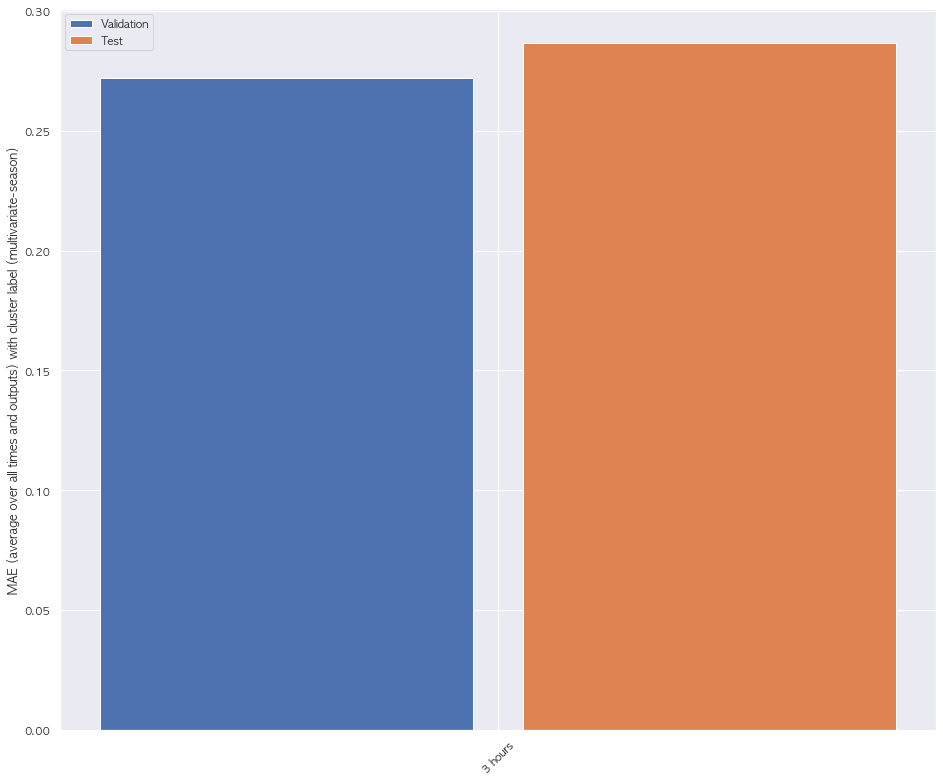

with cluster label (multivariate-week-season)


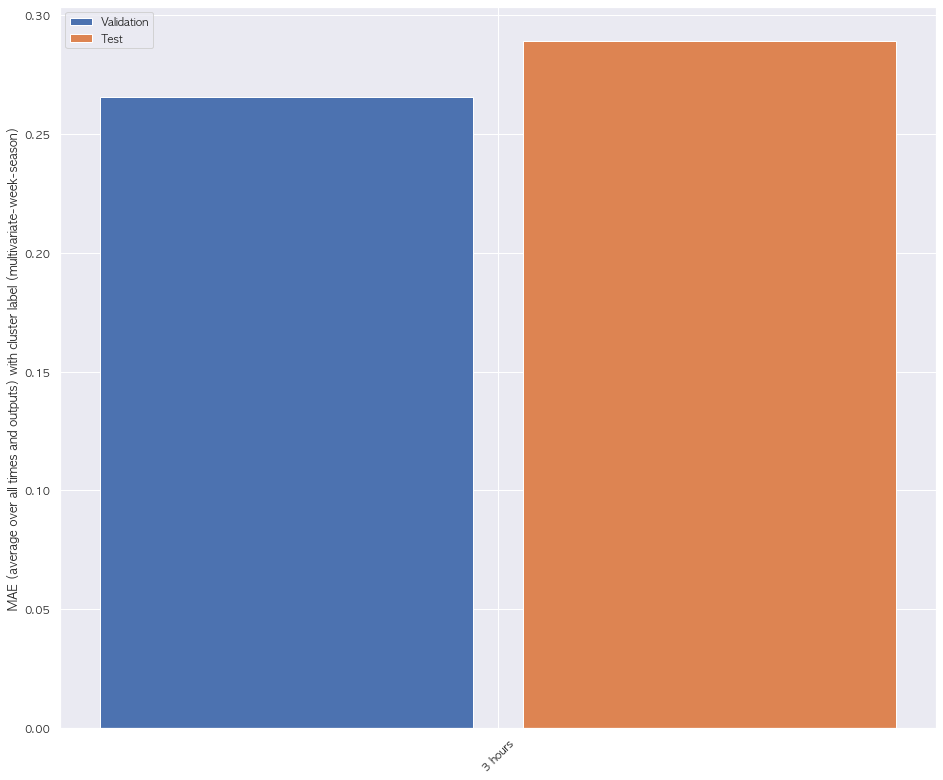

In [58]:
for key in performance.keys():
    print(key)
    cur_val_performance = val_performance[key]
    cur_performance = performance[key]
    
    x = np.arange(len(cur_performance))
    width = 0.3

    metric_name = 'mean_absolute_error'
    metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
    val_mae = [v[metric_index] for v in cur_val_performance.values()]
    test_mae = [v[metric_index] for v in cur_performance.values()]

    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=cur_performance.keys(),
               rotation=45)
    plt.ylabel(f'MAE (average over all times and outputs) {key}')
    _ = plt.legend()
    plt.show()

In [59]:
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

test_df = norm_all_dict['univariate']['test'].copy()
test_df

col_test_df = pd.DataFrame()
for idx in range(0, len(test_df), 24):
    date = test_df.iloc[idx:].index[0]
    col_test_df[date] = test_df.iloc[idx: idx+24]['energy (kw 15min)'].values
mean_pattern = col_test_df.mean(axis=1)

# calc tss, calc wss (only test data)
tss = 0
wss = 0
cluster_distance = np.array([])
cluster_similarity = np.array([])
for idx in range(0, len(test_df), 24):
    date_idxes = test_df[idx: idx+24].index
    
    pattern = test_df.loc[date_idxes]['energy (kw 15min)'].values
    tss += euc(
        mean_pattern[OUT_STEPS:],
        pattern[OUT_STEPS:]
    ) ** 2
    
    c_pattern = norm_cluster_pattern_col.loc[date_idxes]['cluster energy'].values
    c_distance = euc(
        c_pattern[OUT_STEPS:],
        pattern[OUT_STEPS:]
    )
    c_similarity = cos_sim(
        c_pattern[OUT_STEPS:],
        pattern[OUT_STEPS:]
    )
    
    wss += c_distance ** 2
    cluster_distance = np.append(cluster_distance, [c_distance])
    cluster_similarity = np.append(cluster_similarity, [c_similarity])
    
    
cluster_ecv = (1 - (wss / tss)) * 100

evaluate_df = pd.DataFrame(columns=['mae_val','mae_test','ecv', 'mean dis', 'mean sim'])
evaluate_df.loc['cluster pattern'] = [
    0,
    0,
    cluster_ecv,
    cluster_distance.mean(),
    cluster_similarity.mean()
]
evaluate_df

,mae_val,mae_test,ecv,mean dis,mean sim
cluster pattern,0.0,0.0,-362.498455,6.20033,0.114979


In [60]:
predict_data_length = OUT_STEPS
WINDOW_WIDTH = 3
pattern_dict = None
predict_dict = dict()
test_type = "test"

for _ in range(0, round(len(norm_all_dict['univariate'][test_type]) / 24), 50):
    for key in models.keys():
        predict_list = list()
        test_df = norm_all_dict[key]['test']
        feature_length = len(test_df.columns)
        print(_ , key, feature_length)
        cur_model = models[key]

#         if "season" in key:
#             cnt = 0

#             for split in range(0, round(len(test_df)), 24):
#                 h_key = "{} hours".format(WINDOW_WIDTH)

#                 original_x_labels = [idx for idx in range(1,25)]
#                 predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
#                 original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()
                
#                 date = test_df[split:(split + 24)].index[0]
#                 season = get_season(date.month)
                
#                 predicts = np.array([])
#                 for idx in range(0, (24 - predict_data_length), OUT_STEPS):
#                     inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
                    
#                     inputs = inputs.reshape(-1, predict_data_length, feature_length)
#                     result = cur_model[season][h_key](inputs).numpy()[:,:,0].flatten()

#                     predicts = np.append(predicts, result)
#                 predict_list.append(predicts)
#                 cnt += 1
        if ("multivariate" in key) or ("cluster" in key):
            cnt = 0
            for split in range(0, round(len(test_df)), 24):
                h_key = "{} hours".format(WINDOW_WIDTH)

                original_x_labels = [idx for idx in range(1,25)]
                predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
                original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

                predicts = np.array([])
                for idx in range(0, (24 - predict_data_length), OUT_STEPS):
                    inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
                    
                    inputs = inputs.reshape(-1, predict_data_length, feature_length)
                    result = cur_model[h_key](inputs).numpy()[:,:,0].flatten()

                    predicts = np.append(predicts, result)
                predict_list.append(predicts)
                cnt += 1
        else:
            cnt = 0

            for split in range(0, round(len(test_df)), 24):
                h_key = "{} hours".format(WINDOW_WIDTH)

                original_x_labels = [idx for idx in range(1,25)]
                predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
                original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

                predicts = []
                inputs = []

                for idx in range(0, (24 - predict_data_length), OUT_STEPS):
                    inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
                    inputs = inputs.reshape(-1, predict_data_length, feature_length)
                    result = cur_model[h_key](inputs).numpy().flatten()

                    predicts.append(result)
                predict_list.append(predicts)
                cnt += 1
        if key not in predict_dict.keys():
            predict_dict[key] = predict_list
        else:
            predict_dict[key] = np.append(predict_dict[key], predict_list)

0 univariate 1
0 multivariate 8
0 multivariate (ta-rhm) 3
0 multivariate (week) 3
0 multivariate (weather) 2
0 multivariate (season) 2
0 multivariate (week-season) 4
0 with cluster label 2
0 with cluster label (multivariate) 9
0 with cluster label (multivariate-weather) 3
0 with cluster label (multivariate-ta-rhm) 4
0 with cluster label (multivariate-week) 4
0 with cluster label (multivariate-season) 3
0 with cluster label (multivariate-week-season) 5
50 univariate 1
50 multivariate 8
50 multivariate (ta-rhm) 3
50 multivariate (week) 3
50 multivariate (weather) 2
50 multivariate (season) 2
50 multivariate (week-season) 4
50 with cluster label 2
50 with cluster label (multivariate) 9
50 with cluster label (multivariate-weather) 3
50 with cluster label (multivariate-ta-rhm) 4
50 with cluster label (multivariate-week) 4
50 with cluster label (multivariate-season) 3
50 with cluster label (multivariate-week-season) 5


In [61]:
# predict preprocessing
for key in predict_dict.keys():
    predict_dict[key] = predict_dict[key].reshape(-1,24 - OUT_STEPS)
    print(predict_dict[key].shape)

(182, 21)
(182, 21)
(182, 21)
(182, 21)
(182, 21)
(182, 21)
(182, 21)
(182, 21)
(182, 21)
(182, 21)
(182, 21)
(182, 21)
(182, 21)
(182, 21)


In [62]:
test_df = norm_all_dict['univariate'][test_type].copy()

for key in predict_dict.keys():
    wss = 0
    distances = np.array([])
    similarities = np.array([])
    
    for idx in range(0, len(test_df), 24):
        pattern = test_df.iloc[idx: idx+24]['energy (kw 15min)'].values
        
        p_idx = round(idx / 24)
        p_pattern = predict_dict[key][p_idx]
        wss += euc(
            p_pattern,
            pattern[OUT_STEPS:]
        ) ** 2
        
        distance = euc(
            p_pattern,
            pattern[OUT_STEPS:]
        )
        similarity = cos_sim(
            p_pattern,
            pattern[OUT_STEPS:]
        )
        
        distances = np.append(distances, [
            distance
        ])
        similarities = np.append(similarities, [
            similarity
        ])
        
    ecv = (1 - (wss / tss)) * 100
    mean_dis = distances.mean()
    mean_sim = similarities.mean()
    
    evaluate_df.loc[key] = [
        val_performance[key]['3 hours'][0], 
        performance[key]['3 hours'][0], 
        ecv,
        mean_dis,
        mean_sim
    ]

In [63]:
evaluate_df

,mae_val,mae_test,ecv,mean dis,mean sim
cluster pattern,0.000000,0.000000,-362.498455,6.200330,0.114979
univariate,0.136774,0.198695,66.053126,1.680704,0.896542
multivariate,0.179263,0.268061,52.148767,2.026316,0.837073
multivariate (ta-rhm),0.159010,0.216532,60.058690,1.801940,0.868776
multivariate (week),0.129903,0.181416,67.659117,1.625844,0.900254
multivariate (weather),0.136697,0.197145,66.309863,1.673956,0.896367
multivariate (season),0.157146,0.212433,62.774667,1.767556,0.881503
multivariate (week-season),0.144416,0.196569,64.709103,1.699254,0.890183
with cluster label,0.142058,0.165099,71.951716,1.538926,0.918953
with cluster label (multivariate),0.140168,0.224594,56.071711,1.940613,0.863709


In [64]:
evaluate_df[:][1:].sort_values(by=['mae_val','mae_test','ecv'], ascending=[True, True, False])

,mae_val,mae_test,ecv,mean dis,mean sim
multivariate (week),0.129903,0.181416,67.659117,1.625844,0.900254
with cluster label (multivariate-week),0.134460,0.163284,71.516353,1.537667,0.917063
with cluster label (multivariate-week-season),0.135079,0.170748,71.544589,1.555982,0.912378
multivariate (weather),0.136697,0.197145,66.309863,1.673956,0.896367
univariate,0.136774,0.198695,66.053126,1.680704,0.896542
with cluster label (multivariate),0.140168,0.224594,56.071711,1.940613,0.863709
with cluster label,0.142058,0.165099,71.951716,1.538926,0.918953
with cluster label (multivariate-season),0.142659,0.174959,71.335810,1.568918,0.909894
with cluster label (multivariate-weather),0.142804,0.167219,71.885927,1.541236,0.918838
multivariate (week-season),0.144416,0.196569,64.709103,1.699254,0.890183


In [65]:
switch_eval = evaluate_df.copy()

In [45]:
non_switch = evaluate_df.copy()

In [68]:
switch_eval[1:]

,mae_val,mae_test,ecv,mean dis,mean sim
univariate,0.136774,0.198695,66.053126,1.680704,0.896542
multivariate,0.179263,0.268061,52.148767,2.026316,0.837073
multivariate (ta-rhm),0.159010,0.216532,60.058690,1.801940,0.868776
multivariate (week),0.129903,0.181416,67.659117,1.625844,0.900254
multivariate (weather),0.136697,0.197145,66.309863,1.673956,0.896367
multivariate (season),0.157146,0.212433,62.774667,1.767556,0.881503
multivariate (week-season),0.144416,0.196569,64.709103,1.699254,0.890183
with cluster label,0.142058,0.165099,71.951716,1.538926,0.918953
with cluster label (multivariate),0.140168,0.224594,56.071711,1.940613,0.863709
with cluster label (multivariate-weather),0.142804,0.167219,71.885927,1.541236,0.918838


In [69]:
non_switch[1:]

,mae_val,mae_test,ecv,mean dis,mean sim
univariate,0.195535,0.137359,61.021042,1.698026,0.882014
multivariate,0.278628,0.195128,51.355777,1.940142,0.844647
multivariate (ta-rhm),0.216009,0.203540,39.383261,2.135125,0.841176
multivariate (week),0.189564,0.132358,63.665455,1.629094,0.890384
multivariate (weather),0.194933,0.136895,60.980583,1.697449,0.882182
multivariate (season),0.207284,0.152281,56.744977,1.781590,0.868074
multivariate (week-season),0.196850,0.144301,59.707966,1.716526,0.875660
with cluster label,0.146650,0.145712,61.456981,1.672886,0.899400
with cluster label (multivariate),0.210192,0.150128,60.922543,1.707190,0.884265
with cluster label (multivariate-weather),0.147218,0.148695,60.305613,1.702026,0.892863


In [ ]:
# visualization
predict_data_length = OUT_STEPS
WINDOW_WIDTH = 3

for _ in range(0, round(len(norm_all_dict['univariate']['test']) / 24), 50):
    for key in models.keys():
        test_df = \
           norm_all_dict['multivariate']['test'][_ * 24:(_ + 50) * 24] if "multivariate" in key\
            else norm_all_dict['with cluster label']['test'][_ * 24:(_ + 50) * 24] if "cluster" in key\
            else norm_all_dict['univariate']['test'][_ * 24:(_ + 50) * 24]
        feature_length = len(test_df.columns)
        print(_ , key, feature_length)
        cur_model = models[key]

        if "season" in key:
            fig, axes = plt.subplots(math.ceil(round(len(test_df) / 24) / 5),5, figsize=(30,30))
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            cnt = 0

            for split in range(0, round(len(test_df)), 24):
                h_key = "{} hours".format(WINDOW_WIDTH)

                original_x_labels = [idx for idx in range(1,25)]
                predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
                original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

                date = test_df[split:(split + 24)].index[0]
                season = get_season(date.month)

                predicts = np.array([])
                for idx in range(0, (24 - predict_data_length), OUT_STEPS):
                    inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
                    inputs = inputs.reshape(-1, predict_data_length, feature_length)
                    
                    if "multivariate" in key:
                        result = cur_model[season][h_key](inputs).numpy()[:,:,0].flatten()
                    else:
                        result = cur_model[season][h_key](inputs).numpy().flatten()

                    predicts = np.append(predicts, result)

                sns.lineplot(original_x_labels, original, lw=2, ax=axes[
                    math.floor(cnt / 5)
                ][math.floor(cnt % 5)])
                sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
                    math.floor(cnt / 5)
                ][math.floor(cnt % 5)])

                cnt += 1
        elif ("multivariate" in key) or ("cluster" in key):
            fig, axes = plt.subplots(math.ceil(round(len(test_df) / 24) / 5),5, figsize=(30,30))
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            cnt = 0
            for split in range(0, round(len(test_df)), 24):
                h_key = "{} hours".format(WINDOW_WIDTH)

                original_x_labels = [idx for idx in range(1,25)]
                predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
                original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

                predicts = np.array([])
                for idx in range(0, (24 - predict_data_length), OUT_STEPS):
                    inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
                    
                    inputs = inputs.reshape(-1, predict_data_length, feature_length)
                    result = cur_model[h_key](inputs).numpy()[:,:,0].flatten()

                    predicts = np.append(predicts, result)
                sns.lineplot(original_x_labels, original, lw=2, ax=axes[
                    math.floor(cnt / 5)
                ][math.floor(cnt % 5)])
                sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
                    math.floor(cnt / 5)
                ][math.floor(cnt % 5)])

                cnt += 1
        else:
            fig, axes = plt.subplots(math.ceil(round(len(test_df) / 24) / 5),5, figsize=(30,30))
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            cnt = 0

            for split in range(0, round(len(test_df)), 24):
                h_key = "{} hours".format(WINDOW_WIDTH)

                original_x_labels = [idx for idx in range(1,25)]
                predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
                original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

                predicts = np.array([])
                for idx in range(0, (24 - predict_data_length), OUT_STEPS):
                    inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
                    inputs = inputs.reshape(-1, predict_data_length, feature_length)
                    result = cur_model[h_key](inputs).numpy().flatten()

                    predicts = np.append(predicts, result)

                sns.lineplot(original_x_labels, original, lw=2, ax=axes[
                    math.floor(cnt / 5)
                ][math.floor(cnt % 5)])
                sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
                    math.floor(cnt / 5)
                ][math.floor(cnt % 5)])

                cnt += 1
        plt.show()